In [1]:
import math 
import random
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from abc import abstractmethod
from tqdm import tqdm
%matplotlib inline
np.random.seed(20)

# Defining Stationary and Nonstationary Bandits

In [2]:
class Bandit: 
    """
    Each lever has an expected reward randomly drawn
    from a standard normal. When each lever is pulled, 
    the reward received is drawn from a standard normal
    centered at the lever's expected reward
    """
    def __init__(self, k):
        self.means = np.random.normal(size=k)
    
    def pull(self, action):
        return np.random.normal(loc=self.means[action])

In [3]:
class NonStationaryBandit(Bandit):
    """
    Before every pull, chooses a lever at random and resamples
    its expected reward with probability `resample_prob`. 
    """
    def __init__(self, k, resample_prob): 
        super().__init__(k)
        self.resample_prob = resample_prob
    
    def pull(self, action): 
        if random.random() < self.resample_prob:
            i = random.randrange(len(self.means))
            self.means[i] = np.random.normal()
        
        return super().pull(action)

In [4]:
bandit = Bandit(10)
for i in range(10): 
    print(f"lever {i}: ", bandit.pull(i))

lever 0:  1.2073541225329891
lever 1:  -0.29754585987123544
lever 2:  -0.4344802748918949
lever 3:  -3.185629839778695
lever 4:  -2.364335248987937
lever 5:  0.8054114589151509
lever 6:  0.8952745491724602
lever 7:  0.589151510771613
lever 8:  1.5542055197223683
lever 9:  0.8127828945265153


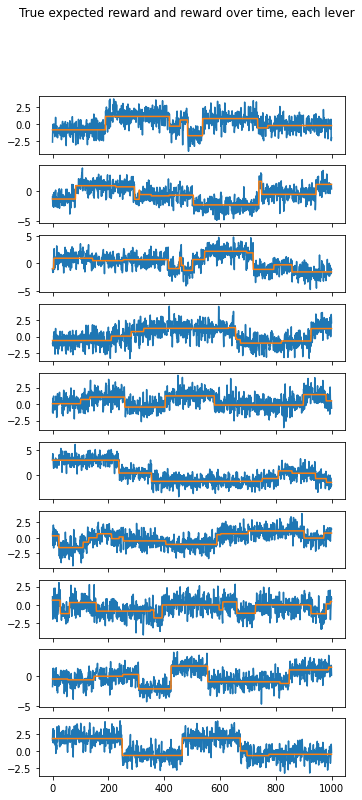

In [18]:
bandit = NonStationaryBandit(10, .05)
lever = 0

fig, axs = plt.subplots(10, 1, sharex=True)

for lever in range(10):
    rewards = []
    mean_rewards = []
    for i in range(1000): 
        bandit.pull(0)
        rewards.append(bandit.pull(lever))
        mean_rewards.append(bandit.means[lever])

    axs[lever].plot(rewards)
    axs[lever].plot(mean_rewards,)
    
fig.suptitle('True expected reward and reward over time, each lever')
fig.set_size_inches(5.5, 12.5)
plt.show()
    

# Bandit Algorithms

In [6]:
class BanditPolicy:     
    @abstractmethod
    def choose(self): 
        return 
    
    @abstractmethod
    def update(self, action, reward):
        return

In [7]:
class ActionValuePolicy(BanditPolicy):
    """
    Base action-value policy that supports eps-greedy exploration, 
    custom step size functions, and optimistic initialization
    """
    def __init__(self, k, eps=0, step_size_fn = lambda n: 1/n, 
                optimistic=True): 
        if optimistic:
            optimistic_init_value = 5. 
            self.values = np.full(k, optimistic_init_value)
        else: 
            self.values = np.zeros(k)
        
        self.n = 0
        self.step_size_fn = step_size_fn
        self.eps = eps
    
    def choose(self):         
        if random.random() < self.eps: 
            return random.randrange(self.values.shape[0])
        else: 
            greedy_idx = np.argmax(self.values)
            return greedy_idx
    
    def update(self, action, reward): 
        self.n += 1
        
        step_size = self.step_size_fn(self.n)
        step = step_size * (reward - self.values[action])
        
        self.values[action] += step

In [8]:
class UCBPolicy(ActionValuePolicy):
    def __init__(self, k, UCB_param, step_size_fn = lambda n: 1/n, 
                optimistic=True): 
        super().__init__(k, step_size_fn=step_size_fn, 
                         optimistic=optimistic)
        self.visits = np.zeros(k, dtype=int)
        self.c = UCB_param
        
    def choose(self): 
        if not self.visits.all():
            return np.argwhere(self.visits==0)[0]
        
        UCB_term = self.c * np.sqrt(math.log(self.n)/self.visits)
        weights = self.values + UCB_term 
        
        return np.argmax(weights)
    
    def update(self, action, reward): 
        super().update(action, reward)
        self.visits[action] += 1

In [9]:
class GradientBandit(BanditPolicy):
    def __init__(self, k, alpha=0.1, step_size_fn = lambda n: 1/n,):
        self.prefs = np.ones(k)
        self.n = 0
        self.step_size_fn = step_size_fn
        self.baseline = None
        self.alpha = alpha
    
    def choose(self): 
        return np.random.choice(len(self.prefs), p=softmax(self.prefs))
    
    def update(self, action, reward): 
        p = softmax(self.prefs)
        if self.baseline: 
            self.baseline = (self.n*self.baseline + reward)/(self.n+1)
        else: 
            self.baseline = reward
            
        self.n += 1
        
        alpha_diff = self.alpha*(reward-self.baseline)
        
        self.prefs[action] += alpha_diff * (1-p[action])
        
        mask = np.ones(len(self.prefs))
        mask[action] = 0 
        self.prefs -= mask*alpha_diff * p 

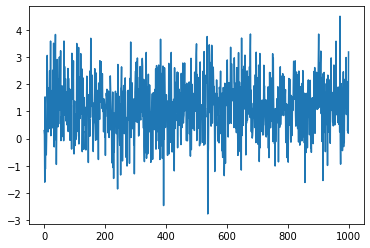

In [10]:
# Test run
bandit = Bandit(10)
policy = GradientBandit(10, 2)

rewards = []
for _ in range(1000):
    action = policy.choose()
    reward = bandit.pull(action)
    rewards.append(reward)
    policy.update(action, reward)
    
plt.plot(rewards)
plt.show()

# Evaluation

In [11]:
def avg_rewards(bandits, policies, num_steps):
    assert len(bandits) == len(policies)
    
    avg_rewards = []
    for _ in tqdm(range(num_steps)): 
        actions = [x.choose() for x in policies]
        rewards = [b.pull(a) for b, a in zip(bandits, actions)]
        [x.update(a, r) for x, a, r in zip(policies, actions, rewards)]
        
        avg_reward = sum(rewards)/len(rewards)
        avg_rewards.append(avg_reward)
    
    return avg_rewards

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.00it/s]


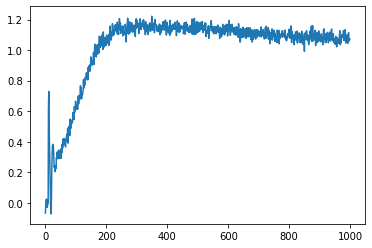

In [22]:
m = 2000
k = 10 
num_steps = 1000

bandits = [NonStationaryBandit(k, resample_prob=0.05) for _ in range(m)]
pols = [ActionValuePolicy(k, eps=0.1, 
                         step_size_fn = lambda x: 0.1) for _ in range(m)]

rewards = avg_rewards(bandits, pols, num_steps)

plt.plot(rewards)
plt.show()